# Context : Data cleaning and Feature engineering




Source : 


**Competition Description**



xxxx

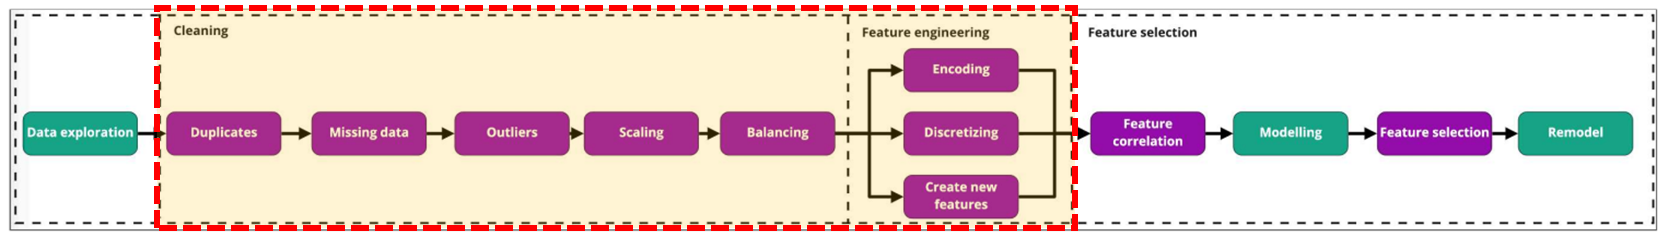



# Imports

In [1]:
import warnings
warnings.filterwarnings(action = 'ignore')

import pandas as pd
pd.options.display.max_columns = None
import numpy as np
from scipy.stats import iqr

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder



# Retrieve data

In [2]:
#Retrieve data
path_to_data = '../raw_data/'
data = pd.read_csv(path_to_data + 'train.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
#List the columns that won't be used (exemple : Id, Name, ...)
cols_to_drop = ['Id']

data = data.drop(columns=cols_to_drop)
data.shape


(1460, 80)

In [4]:
# Save initial number of columns
initial_number_cols = data.shape[1]
initial_number_cols

80

In [5]:
# list processed columns
processed = []
processed.append('Id')
processed

['Id']

# Cleaning Duplicates


In [6]:
# Check number of rows before removing duplicates
print(f"Number of rows : {len(data)}")

# Compute the number of duplicated rows
print(f"Number of duplicated rows : {data.duplicated().sum()}")

# Remove duplicates
# data = data.drop_duplicates() 

Number of rows : 1460
Number of duplicated rows : 0


# Cleaning Missing Data


<span style="font-family:Comic Sans MS; color:red">Let's check the missing data per column (in percentage) :  </span>

In [7]:
def get_missing_data(data):       
    # Counting the percentage of NaN for each column
    missing_data = data.isnull().sum().sort_values(ascending=False)/len(data)*100 #NaN percentage for each column

    # missing_data
    missing_data = missing_data[missing_data > 0]

    #Missing data column names
    missing_cols = missing_data.index.values.tolist()

    #Show missing data in percent
    return missing_data

missing_data = get_missing_data(data)
missing_data

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageCond       5.547945
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtCond         2.534247
BsmtQual         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
dtype: float64

## Missing values > Max_threshold



In [8]:
# Threshold for which we decide to drop the column
max_thres_missing = 90

# Retrieve the feature name of columns exceeding max threshold for missing values. 
high_missing_cols = missing_data[missing_data > 90].index.values.tolist()

high_missing_cols

['PoolQC', 'MiscFeature', 'Alley']

<span style="font-family:Comic Sans MS; color:red">If the missing values of a column exceeds a max threshold, we drop said columns from dataset :  </span>



In [9]:
# More than 90% is way too high, let's drop these features
for col in high_missing_cols:
    data.drop(columns=col, inplace=True)
    print(f"-- **{col}** has more than {max_thres_missing}% of missing values so {col} has been dropped from dataset\n")

-- **PoolQC** has more than 90% of missing values so PoolQC has been dropped from dataset

-- **MiscFeature** has more than 90% of missing values so MiscFeature has been dropped from dataset

-- **Alley** has more than 90% of missing values so Alley has been dropped from dataset



In [10]:
print(f"We dropped the following columns : {high_missing_cols} ! ")

We dropped the following columns : ['PoolQC', 'MiscFeature', 'Alley'] ! 


In [11]:
# list processed columns
for col in high_missing_cols:
    processed.append(col)

processed

['Id', 'PoolQC', 'MiscFeature', 'Alley']

<span style="font-family:Comic Sans MS; color:red">Let's display the remaining missing data :  </span>



In [12]:
# Display the remaining missing data
missing_data = get_missing_data(data)
missing_data

Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
GarageYrBlt      5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtQual         2.534247
BsmtFinType1     2.534247
BsmtCond         2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
dtype: float64

In [13]:
# Determine type of missing columns
columns_missing = missing_data.index.values.tolist()
missing_cols_type = data[columns_missing].dtypes

#Identify the categorical columns with missing values
missing_cols_categorical = missing_cols_type[missing_cols_type == 'object'].index.values.tolist()
missing_cols_categorical;

#Identify the numerical columns with missing values
missing_cols_numerical = missing_cols_type[missing_cols_type != 'object'].index.values.tolist()
missing_cols_numerical;

<span style="font-family:Comic Sans MS; color:red">Let's display the categorical columns with missing values :  </span>



In [14]:
missing_cols_categorical

['Fence',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'BsmtFinType2',
 'BsmtExposure',
 'BsmtQual',
 'BsmtFinType1',
 'BsmtCond',
 'MasVnrType',
 'Electrical']

<span style="font-family:Comic Sans MS; color:red">Let's display the numerical columns with missing values :  </span>

In [15]:
missing_cols_numerical

['LotFrontage', 'GarageYrBlt', 'MasVnrArea']

### Missing values : Categorical columns


<span style="font-family:Comic Sans MS; color:red">/!\ It is important to check the meaning of a NAN value in the documentation !  </span>


<span style="font-family:Comic Sans MS; color:red">/!\ If np.nan can be replaced by "NA", we use a simple imputer !  </span>



In [16]:
# Replace nan values by a replacement value
replace_value = "NA"

#Simple Imputer for nan values    
nan_imputer = SimpleImputer(missing_values = np.nan,          
                      strategy='constant', 
                      fill_value = replace_value)

In [17]:
#Check for unique values of each categorical col, 
#Replace nan values by a replacement value 
#and finally perform a value counts.
for col in missing_cols_categorical:
    print(f"-------------  {col}  ----------------------------------")
    print( f"Unique values: {data[col].unique()}\n")
    data[col] = nan_imputer.fit_transform(data[[col]])
    print(f"Nans have been replaced by {replace_value}.\n")
    print(data[col].value_counts()) 
    print(f"--------------------------------------------------------\n")

-------------  Fence  ----------------------------------
Unique values: [nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']

Nans have been replaced by NA.

NA       1179
MnPrv     157
GdPrv      59
GdWo       54
MnWw       11
Name: Fence, dtype: int64
--------------------------------------------------------

-------------  FireplaceQu  ----------------------------------
Unique values: [nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']

Nans have been replaced by NA.

NA    690
Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64
--------------------------------------------------------

-------------  GarageType  ----------------------------------
Unique values: ['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']

Nans have been replaced by NA.

Attchd     870
Detchd     387
BuiltIn     88
NA          81
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64
--------------------------------------------------------

-------------  GarageFinish  -----------------

In [18]:
# list processed columns
for col in missing_cols_categorical:
    processed.append(col)

processed

['Id',
 'PoolQC',
 'MiscFeature',
 'Alley',
 'Fence',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'BsmtFinType2',
 'BsmtExposure',
 'BsmtQual',
 'BsmtFinType1',
 'BsmtCond',
 'MasVnrType',
 'Electrical']

### Missing values : Numerical columns


<span style="font-family:Comic Sans MS; color:red">Let's draw the histograms to have an idea of the distribution of the numerical columns that have missing values ! </span>




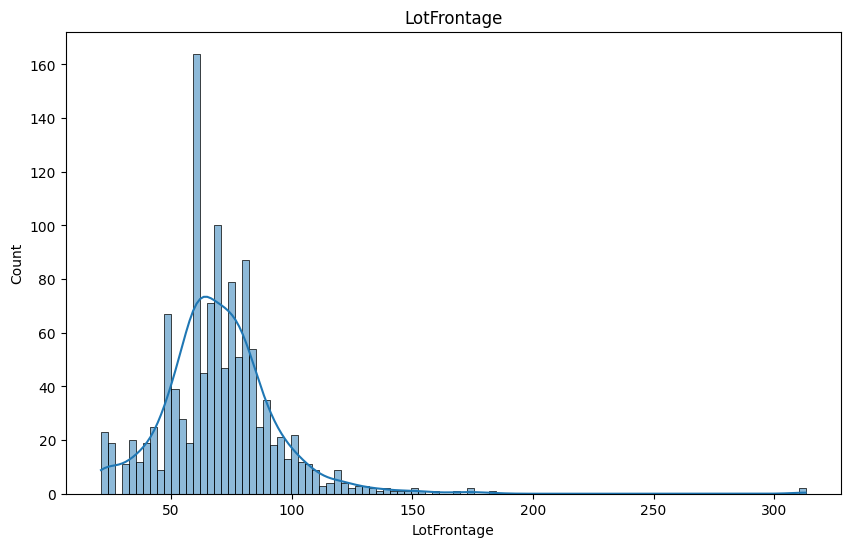

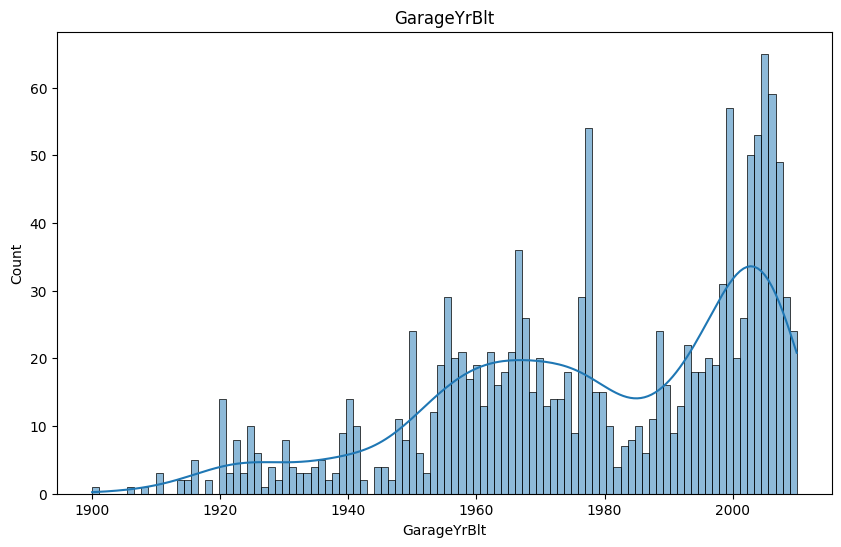

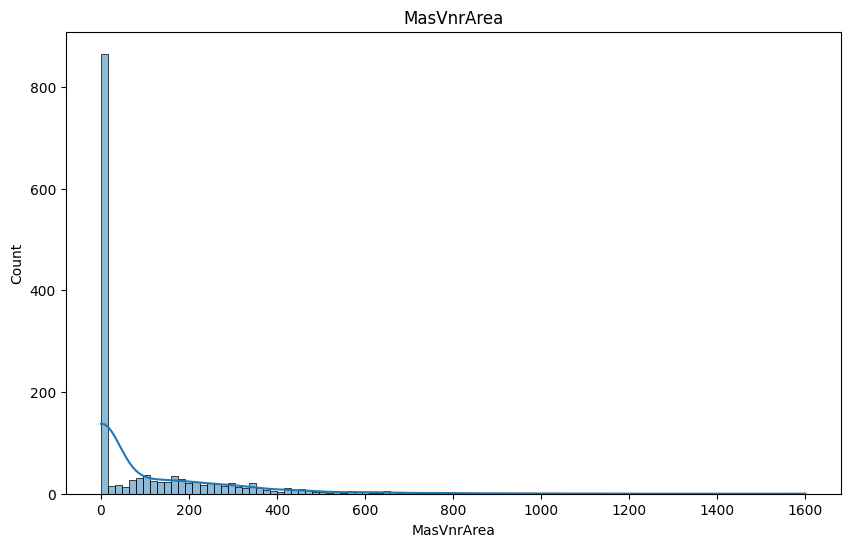

In [19]:
# Display hist plots for numerical features with missing values.
for col in missing_cols_numerical:   
    plt.figure(figsize=(10, 6))
    sns.histplot(data[col], kde=True, bins=100)   
    plt.title(f'{col}')
    

In [20]:
# Display statistics of numerical features with missing values.
for col in missing_cols_numerical:   
    print(f"-------------  {col}  ----------------------------------")
    print(data[col].describe())
    print(f"--------------------------------------------------------\n")
    

-------------  LotFrontage  ----------------------------------
count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64
--------------------------------------------------------

-------------  GarageYrBlt  ----------------------------------
count    1379.000000
mean     1978.506164
std        24.689725
min      1900.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64
--------------------------------------------------------

-------------  MasVnrArea  ----------------------------------
count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1600.000000
Name: MasVnrArea, dtype: float64
--------------------------------------------------------



#### Replace with mean value


<span style="font-family:Comic Sans MS; color:red"> We choose to impute the nan values by the mean value of the distribution ! </span>





<span style="font-family:Comic Sans MS; color:red"> /!\ Human input here : </span>






In [21]:
# List the columns with missing value to be replaced by MEAN value !
missing_cols_numerical_mean = ['LotFrontage']
mean_imputer = SimpleImputer(strategy='mean')

#Fit transform
for col in missing_cols_numerical_mean:
    data[col] = mean_imputer.fit_transform(data[[col]])   

In [22]:
# list processed columns
for col in missing_cols_numerical_mean:
    processed.append(col)

processed

['Id',
 'PoolQC',
 'MiscFeature',
 'Alley',
 'Fence',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'BsmtFinType2',
 'BsmtExposure',
 'BsmtQual',
 'BsmtFinType1',
 'BsmtCond',
 'MasVnrType',
 'Electrical',
 'LotFrontage']

#### Replace by most_frequent

<span style="font-family:Comic Sans MS; color:red"> We choose to impute the nan values by the most frequent value of the distribution ! </span>






<span style="font-family:Comic Sans MS; color:red"> /!\ Human input here : </span>






In [23]:
# List the columns with missing value to be replaced by MOST FREQUENT value !
missing_cols_numerical_most_freq = ['MasVnrArea','GarageYrBlt']
most_frequent_imputer = SimpleImputer(strategy='most_frequent')

#Fit transform
for col in missing_cols_numerical_most_freq:
    data[col] = most_frequent_imputer.fit_transform(data[[col]])  

In [24]:
# list processed columns
for col in missing_cols_numerical_most_freq:
    processed.append(col)

processed


['Id',
 'PoolQC',
 'MiscFeature',
 'Alley',
 'Fence',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'BsmtFinType2',
 'BsmtExposure',
 'BsmtQual',
 'BsmtFinType1',
 'BsmtCond',
 'MasVnrType',
 'Electrical',
 'LotFrontage',
 'MasVnrArea',
 'GarageYrBlt']

### Final check for missing values

In [25]:
# Display the remaining missing data
missing_data = get_missing_data(data)
missing_data

Series([], dtype: float64)

# Check outliers

In [26]:
# Extract numerical columns from original dataset
numerical_columns = data.select_dtypes(include = np.number).columns

#We don't take SalePrice into account on purpose
numerical_columns = numerical_columns.drop('SalePrice') 
numerical_columns.shape


(36,)

## Visual check for outliers


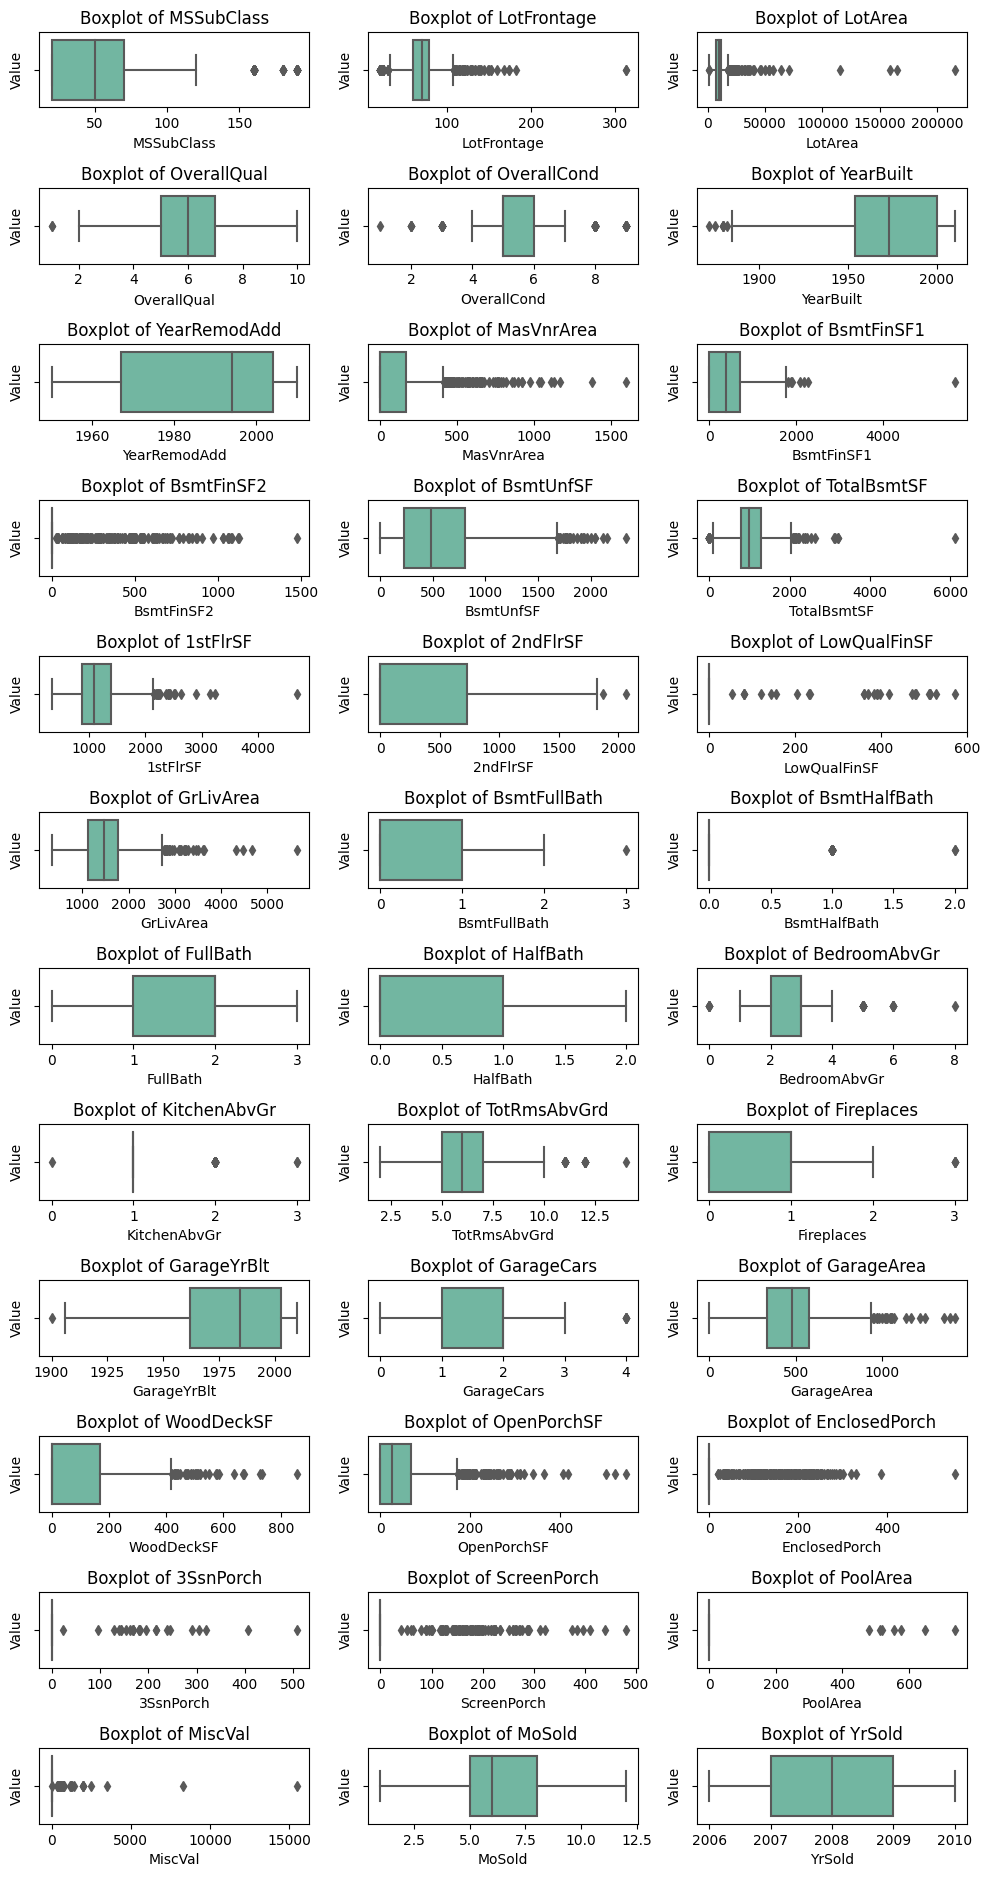

In [27]:
# Plot boxplots of each numerical column
plt.figure(figsize=(10, 20))

for i, column in enumerate(numerical_columns, 1):
    plt.subplot(13, 3, i)    
    sns.boxplot(x=data[column], palette='Set2')
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.ylabel('Value')

plt.tight_layout()
plt.show()


<span style="font-family:Comic Sans MS; color:red">Plot a specific boxplot. Insert column name below : </span>


In [28]:
specific_column = 'MSSubClass'

Text(0, 0.5, 'Value')

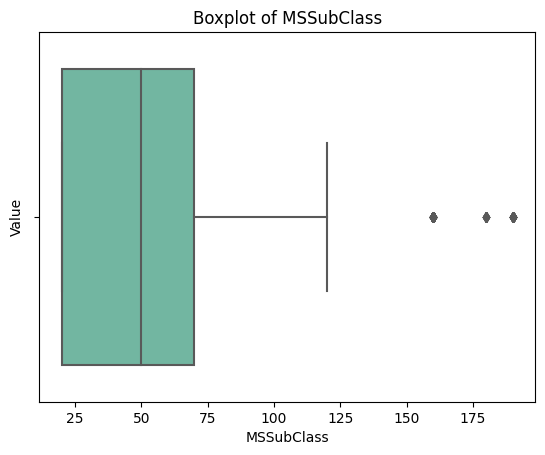

In [29]:
# Plot a specific boxplot
sns.boxplot(x=data[specific_column], palette='Set2')
plt.title(f'Boxplot of {specific_column}')
plt.xlabel(specific_column)
plt.ylabel('Value')

## Numerical check for outliers


<span style="font-family:Comic Sans MS; color:red"> Let's numerically extract the columns with outliers ! </span>


In [30]:
# Identify the columns with outliers
numerical_columns_w_outliers = []
numerical_columns_no_outliers = []

for col in numerical_columns: 
    # Calculate IQR
    iqr_value = iqr(data[col])

    #Calculate 1st quartile
    q1 = np.percentile(data[col],25)

    #Calculate 3rd quartile
    q3 = np.percentile(data[col],75)

    #Calculate lower limit below which data point is considered an outlier
    outlier_lim_low = q1 - 1.5 * iqr_value

    #Calculate higher limit above which data point is considered an outlier
    outlier_lim_high = q3 + 1.5 * iqr_value
    
    #Calculate number of 'low' outliers
    outlier_condition_low = data[col] < outlier_lim_low
    number_outliers_low = len(data[outlier_condition_low][col])
    
    #Calculate number of 'high' outliers
    outlier_condition_high = data[col] > outlier_lim_high
    number_outliers_high = len(data[outlier_condition_high][col])
    
    #Calculate total number of outliers
    number_outliers_total = number_outliers_low + number_outliers_high
    
#     print(f'------------------  {col}  -----------------------')
#     print(f'Number of outliers : {number_outliers_total}')
#     print('---------------------------------------------------')
    
    #If any outliers in column, column is added to a list of columns with outliers
    if number_outliers_total > 0:
        numerical_columns_w_outliers.append(col)
    elif number_outliers_total == 0:
        numerical_columns_no_outliers.append(col)

<span style="font-family:Comic Sans MS; color:red">Let's display the numerical columns WITH outliers :  </span>



In [31]:
numerical_columns_w_outliers

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal']

<span style="font-family:Comic Sans MS; color:red">Let's display the numerical columns WITHOUT outliers :  </span>



In [32]:
numerical_columns_no_outliers

['YearRemodAdd', 'FullBath', 'HalfBath', 'MoSold', 'YrSold']

# Scaling




## Columns WITH outliers : Robust scaling




<span style="font-family:Comic Sans MS; color:red">We consider using Robust scaling for columns WITH outliers !  </span>




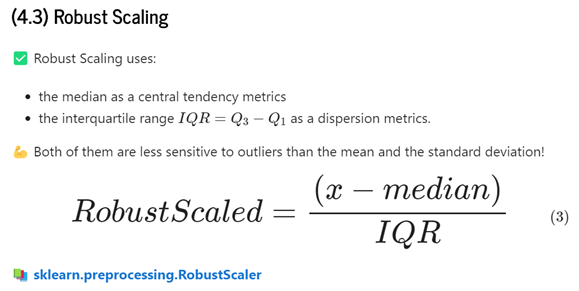


In [33]:
# Describe columns with outliers
data[numerical_columns_w_outliers].describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,103.117123,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,2.866438,1.046575,6.517808,0.613014,1979.976027,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041
std,42.300571,22.024023,9981.264932,1.382997,1.112799,30.202904,180.731373,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.815778,0.220338,1.625393,0.644666,24.749688,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1962.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.000000,70.049958,9478.500000,6.000000,5.000000,1973.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1984.500000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,164.250000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,3.000000,1.000000,7.000000,1.000000,2003.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000


In [34]:
#Instanciate, fit, transform with robust scaler
rb_scaler = RobustScaler()
data[numerical_columns_w_outliers] = rb_scaler.fit_transform(data[numerical_columns_w_outliers])

In [35]:
# Describe columns with outliers after robust scaling
data[numerical_columns_w_outliers].describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
count,1460.000000,1.460000e+03,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,0.137945,-2.895705e-16,0.256504,0.049658,0.575342,-0.037656,0.627806,0.084436,46.549315,0.153402,0.131203,0.148506,0.476638,5.844521,0.079511,0.425342,0.057534,-0.133562,0.046575,0.258904,-0.386986,-0.110341,-0.232877,-0.029068,0.560979,0.318533,21.954110,3.409589,15.060959,2.758904,43.489041
std,0.846011,1.159159e+00,2.465728,0.691498,1.112799,0.656585,1.100343,0.640362,161.319273,0.755328,0.873045,0.759132,0.599627,48.623081,0.811866,0.518911,0.238753,0.815778,0.220338,0.812697,0.644666,0.603651,0.747315,0.885320,0.746064,0.974353,61.119149,29.317331,55.757415,40.177307,496.123024
min,-0.600000,-2.581577e+00,-2.020380,-2.500000,-4.000000,-2.195652,0.000000,-0.538435,0.000000,-0.816239,-1.973134,-1.478645,0.000000,0.000000,-1.745848,0.000000,0.000000,-3.000000,-1.000000,-2.000000,-1.000000,-2.060976,-2.000000,-1.987578,0.000000,-0.367647,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.600000,-5.289452e-01,-0.475543,-0.500000,0.000000,-0.413043,0.000000,-0.538435,0.000000,-0.435043,-0.389552,-0.402553,0.000000,0.000000,-0.516802,0.000000,0.000000,-1.000000,0.000000,-0.500000,-1.000000,-0.548780,-1.000000,-0.602484,0.000000,-0.367647,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.400000,4.710548e-01,0.524457,0.500000,1.000000,0.586957,1.000000,0.461565,0.000000,0.564957,0.610448,0.597447,1.000000,0.000000,0.483198,1.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.451220,0.000000,0.397516,1.000000,0.632353,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.800000,1.278684e+01,50.831645,2.000000,4.000000,0.804348,9.741248,7.385749,1474.000000,3.176923,10.186070,7.079038,2.836538,572.000000,6.455002,3.000000,2.000000,5.000000,2.000000,4.000000,2.000000,0.621951,2.000000,3.884058,5.101190,7.676471,552.000000,508.000000,480.000000,738.000000,15500.000000


In [36]:
# list processed columns
for col in numerical_columns_w_outliers:
    processed.append(col)

## Columns WITHOUT outliers



### Quick visual check




<span style="font-family:Comic Sans MS; color:red">Quick visual check for columns WITHOUT outliers !  </span>


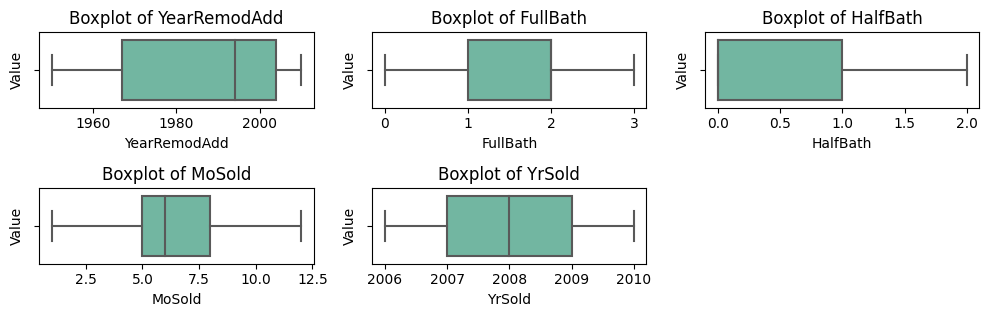

In [37]:
# display boxplots of columns with no outliers
plt.figure(figsize=(10, 20))

for i, column in enumerate(numerical_columns_no_outliers, 1):
    plt.subplot(13, 3, i)    
    sns.boxplot(x=data[column], palette='Set2')
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.ylabel('Value')

plt.tight_layout()
plt.show()

### Distribution of columns WITHOUT outliers



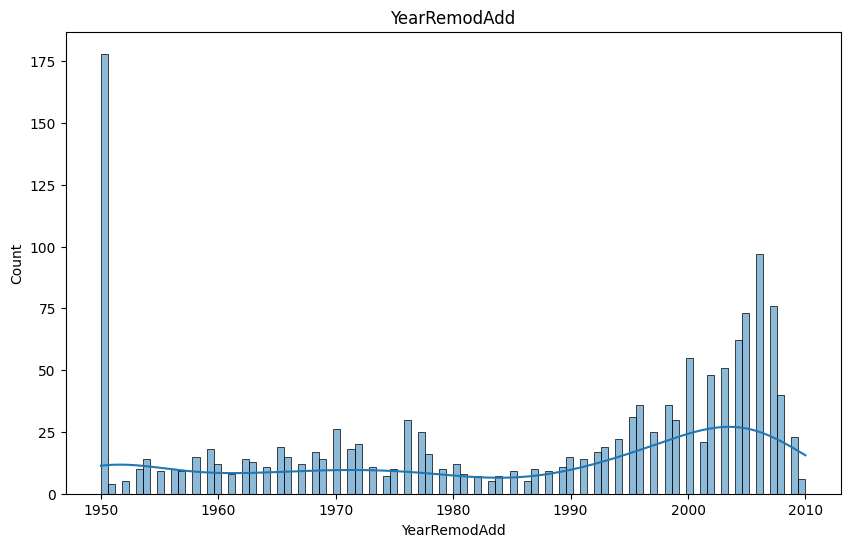

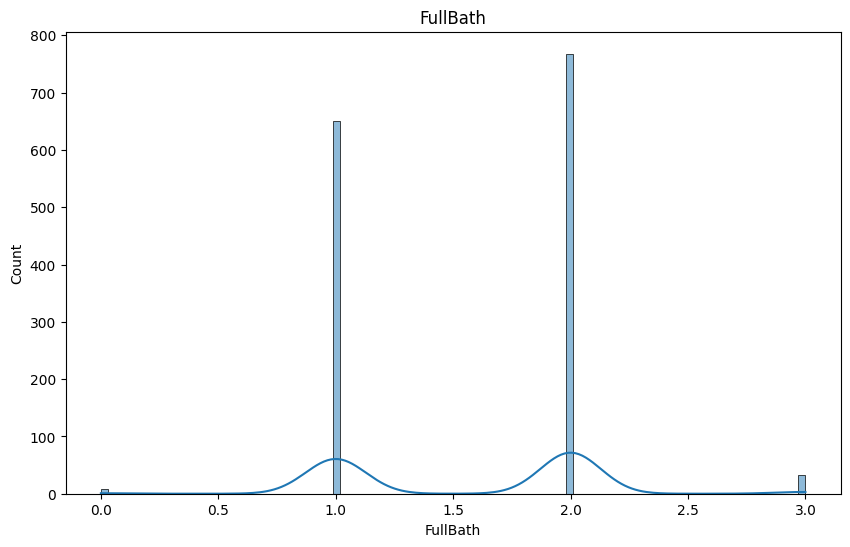

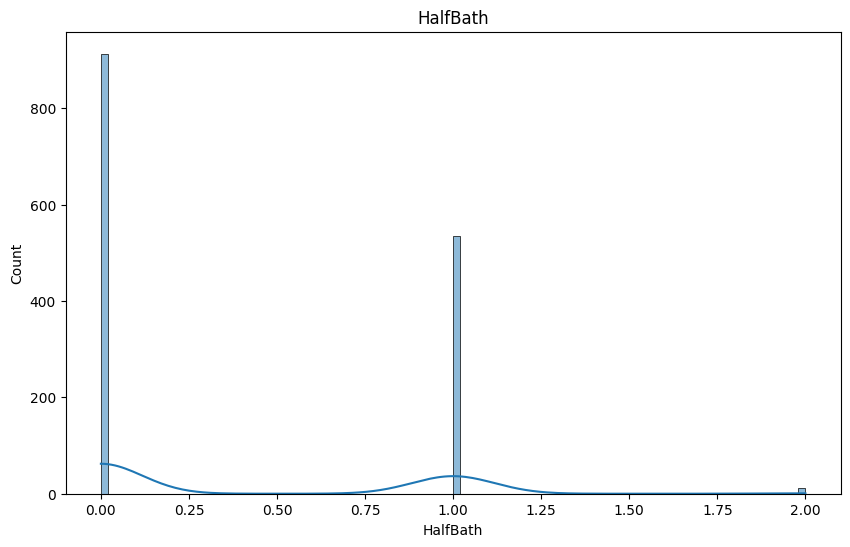

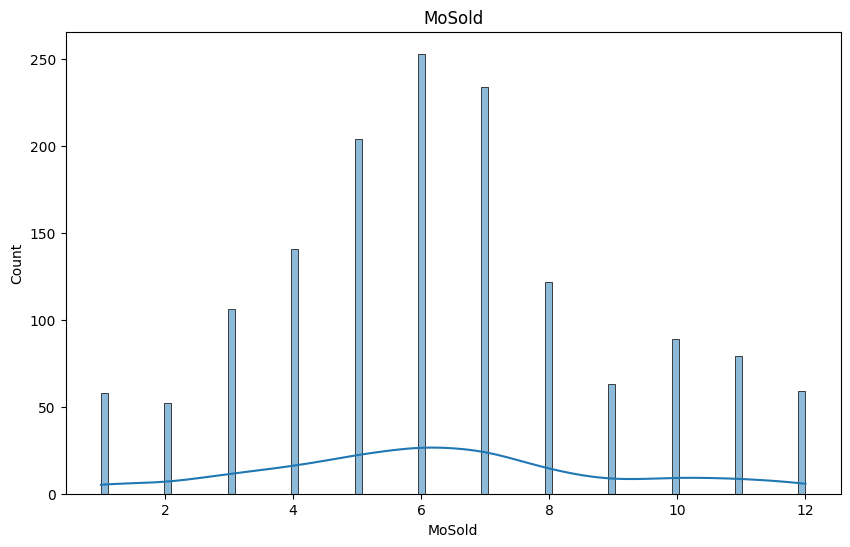

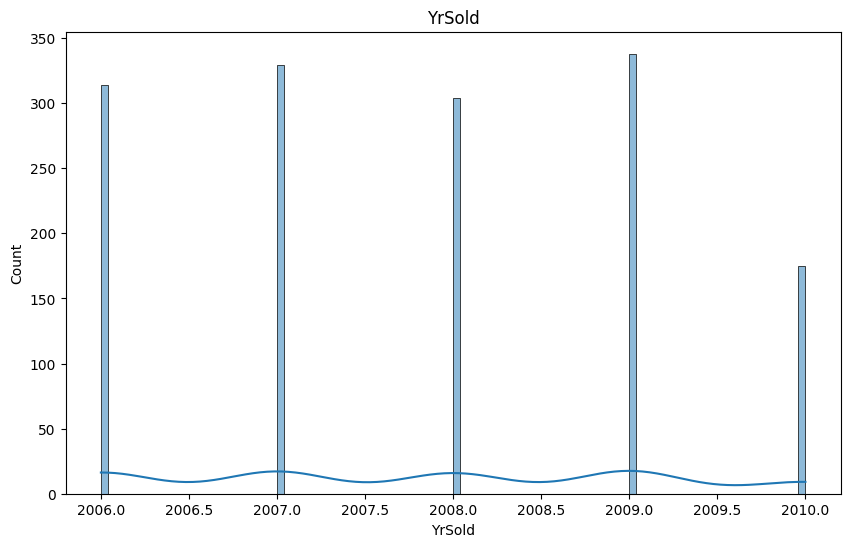

In [38]:
# Display hist plots for numerical features with no outliers.
for col in numerical_columns_no_outliers:
    plt.figure(figsize=(10, 6))
    sns.histplot(data[col], kde=True, bins=100)   
    plt.title(f'{col}')
    

###  Implement Minmax Scaling



<span style="font-family:Comic Sans MS; color:red">We consider using Robust scaling for columns WITH outliers !  </span>




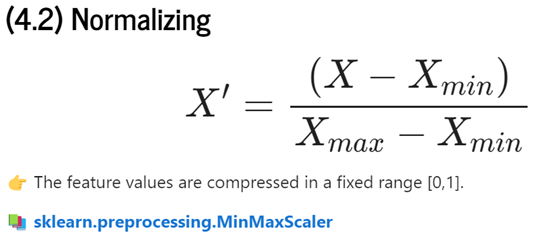


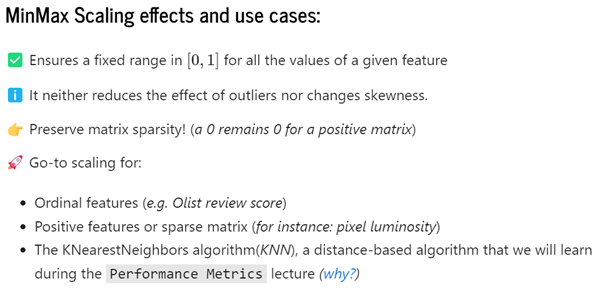


In [39]:
# Describe columns with NO outliers
data[numerical_columns_no_outliers].describe()

,YearRemodAdd,FullBath,HalfBath,MoSold,YrSold
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,1984.865753,1.565068,0.382877,6.321918,2007.815753
std,20.645407,0.550916,0.502885,2.703626,1.328095
min,1950.000000,0.000000,0.000000,1.000000,2006.000000
25%,1967.000000,1.000000,0.000000,5.000000,2007.000000
50%,1994.000000,2.000000,0.000000,6.000000,2008.000000
75%,2004.000000,2.000000,1.000000,8.000000,2009.000000
max,2010.000000,3.000000,2.000000,12.000000,2010.000000


In [40]:
#Instanciate, fit, transform with minmax scaler
minmax_scaler = MinMaxScaler()
data[numerical_columns_no_outliers] = minmax_scaler.fit_transform(data[numerical_columns_no_outliers])

In [41]:
# Describe columns with NO outliers after minmax scaling
data[numerical_columns_no_outliers].describe()

,YearRemodAdd,FullBath,HalfBath,MoSold,YrSold
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,0.581096,0.521689,0.191438,0.483811,0.453938
std,0.344090,0.183639,0.251443,0.245784,0.332024
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.283333,0.333333,0.000000,0.363636,0.250000
50%,0.733333,0.666667,0.000000,0.454545,0.500000
75%,0.900000,0.666667,0.500000,0.636364,0.750000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [42]:
# list processed columns
for col in numerical_columns_no_outliers:
    processed.append(col)

# Balancing

<span style="font-family:Comic Sans MS; color:red"> TO BE DEFINED !  </span>





# Encoding


In [43]:
# Extract categorical columns from original dataset
categorical_columns = data.select_dtypes(include = 'object').columns
categorical_columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'Fence', 'SaleType', 'SaleCondition'],
      dtype='object')

## One hot encoder


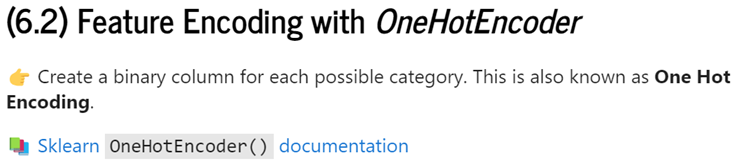


<span style="font-family:Comic Sans MS; color:red"> Let's MANUALLY extract the categorical columns that will be OneHotEncoded !  </span>







<span style="font-family:Comic Sans MS; color:red"> /!\ It is necessary to read the associated documentation !  </span>








In [44]:
# Categorical columns to be encoded with OneHotEncoder
categorical_columns_ohe = ['MSZoning', 'Street','LotShape',
                           'LandContour','Utilities','LotConfig','LandSlope',
                           'Neighborhood','Condition1','Condition2','BldgType',
                           'HouseStyle', 'RoofStyle', 'RoofMatl','Exterior1st',
                           'Exterior2nd','MasVnrType','Foundation','Heating', 
                           'CentralAir','Electrical','Functional','GarageType',
                           'PavedDrive','Fence','SaleType','SaleCondition']


In [45]:
# Instantiate, fit
ohe_encoder = OneHotEncoder(sparse_output=False,drop = 'if_binary')
ohe_encoder.fit(data[categorical_columns_ohe])

#Transform 
data[ohe_encoder.get_feature_names_out()] = ohe_encoder.transform(data[categorical_columns_ohe]);
print(data.shape)

#Drop initial features
data.drop(columns=categorical_columns_ohe, inplace=True)
print(data.shape)


(1460, 261)
(1460, 234)


In [46]:
# list processed columns
for col in categorical_columns_ohe:
    processed.append(col)

## Ordinal encoder


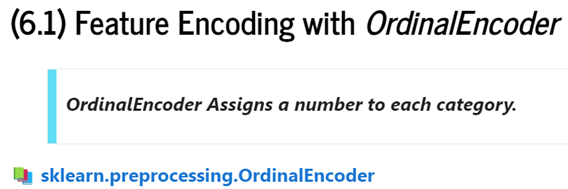


<span style="font-family:Comic Sans MS; color:red"> Let's MANUALLY extract the categorical columns that will be Encoded Ordinally !  </span>








<span style="font-family:Comic Sans MS; color:red"> /!\ It is necessary to read the associated documentation !  </span>








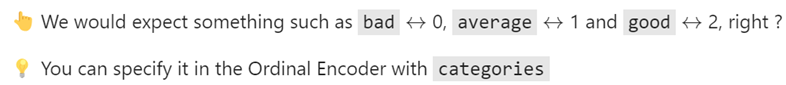


In [47]:
# Categorical columns to be encoded with OrdinalEncoder
categorical_columns_ordinal = ['ExterQual','ExterCond','BsmtQual','BsmtCond', 
                               'BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC',
                               'KitchenQual','FireplaceQu','GarageFinish','GarageQual',
                               'GarageCond']

In [48]:
# Ordering the 'lowest' category to the 'highest' category in ordinal categorical features 
# (KEEP THE ORDER of XXX_cat AND in the subsequent lists)

ExterQual_cat = ['Po','Fa','TA','Gd','Ex']
ExterCond_cat = ['Po','Fa','TA','Gd','Ex']

BsmtQual_cat = ['NA','Po','Fa','TA','Gd','Ex']
BsmtCond_cat = ['NA','Po','Fa','TA','Gd','Ex']

BsmtExposure_cat = ['NA','No','Mn','Av','Gd']

BsmtFinType1_cat = ['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ']
BsmtFinType2_cat = ['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ']

HeatingQC_cat = ['Po','Fa','TA','Gd','Ex']
KitchenQual_cat = ['Po','Fa','TA','Gd','Ex']

FireplaceQu_cat = ['NA','Po','Fa','TA','Gd','Ex']

GarageFinish_cat = ['NA','Unf','RFn','Fin']

GarageQual_cat = ['NA','Po','Fa','TA','Gd','Ex']
GarageCond_cat = ['NA','Po','Fa','TA','Gd','Ex']

ordered_categories = [ExterQual_cat, ExterCond_cat,BsmtQual_cat,BsmtCond_cat,
                      BsmtExposure_cat, BsmtFinType1_cat, BsmtFinType2_cat,
                      HeatingQC_cat, KitchenQual_cat, FireplaceQu_cat,
                      GarageFinish_cat, GarageQual_cat, GarageCond_cat]


In [49]:
# Instantiate, fit using ordinal encoding
ordinal_encoder = OrdinalEncoder(categories = ordered_categories)
ordinal_encoder.fit(data[categorical_columns_ordinal]);

#Transform
data[ordinal_encoder.get_feature_names_out()] = ordinal_encoder.transform(data[categorical_columns_ordinal])

print(data.shape)

(1460, 234)


In [50]:
# list processed columns
for col in categorical_columns_ordinal:
    processed.append(col)

# Check all columns have been processed


In [51]:
# Check that initial columns have all been adressed : 
len(np.unique(processed)) == initial_number_cols

True